# Disaster Tweet Classification

**Objective:** Create a deep learning model to classify tweets as either referring to real disasters or not. During crisis situations, social media platforms like Twitter become active channels for communication, but not all posts that contain disaster-related keywords actually refer to real emergencies. Distinguishing between tweets about actual disasters and those that use disaster-related terms in non-emergency contexts is crucial for effective emergency response.

**Dataset:** The dataset contains tweets labeled as either real disasters (1) or not (0).  The goal is to build a model to classify tweets based on their content.

## 1. Setup and Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

np.random.seed(42)
tf.random.set_seed(42)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/saravi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Data Loading and Exploration

We'll use a dataset of tweets that have been manually classified as either referring to real disasters (1) or not (0).

In [2]:
df = pd.read_csv("~/nlp-getting-started/train.csv")

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset shape: (7613, 5)

First few rows:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("Missing values:")
df.isnull().sum()

Missing values:


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Target distribution:
0    4342
1    3271
Name: target, dtype: int64


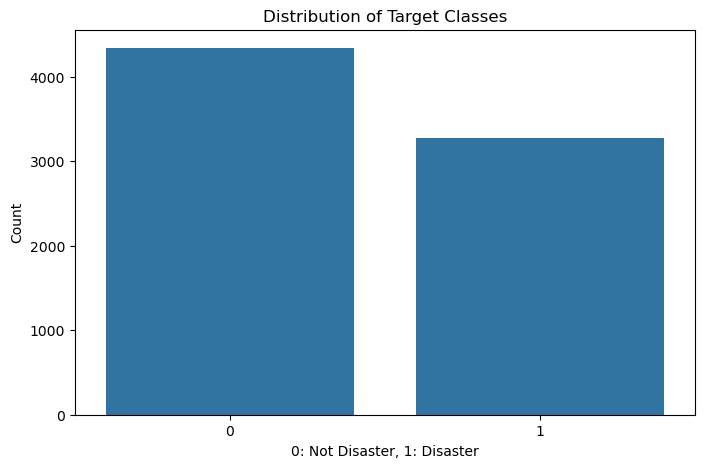

In [4]:
target_counts = df['target'].value_counts()
print("Target distribution:")
print(target_counts)

plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Classes')
plt.xlabel('0: Not Disaster, 1: Disaster')
plt.ylabel('Count')
plt.show()

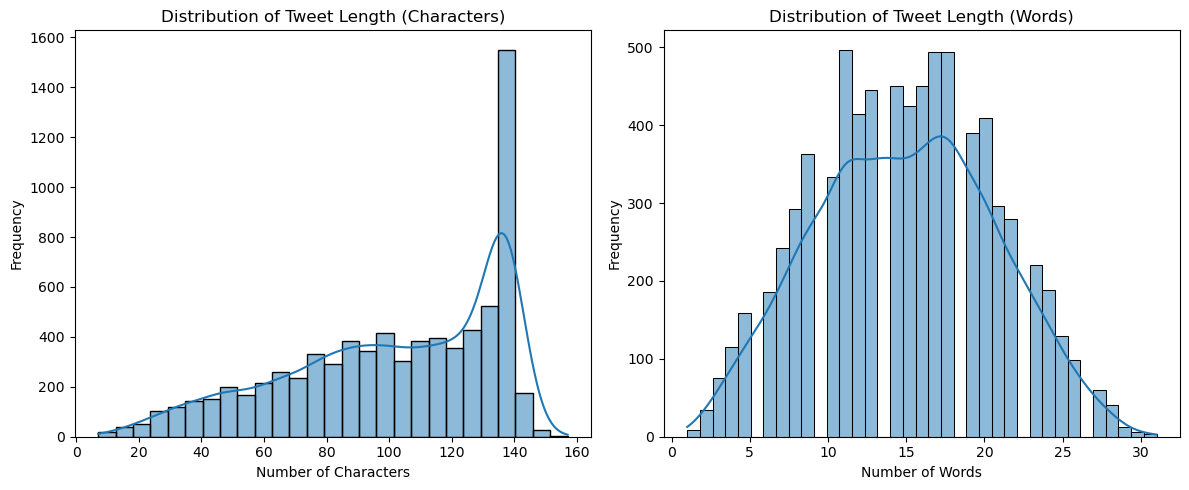

In [5]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Tweet Length (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Tweet Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

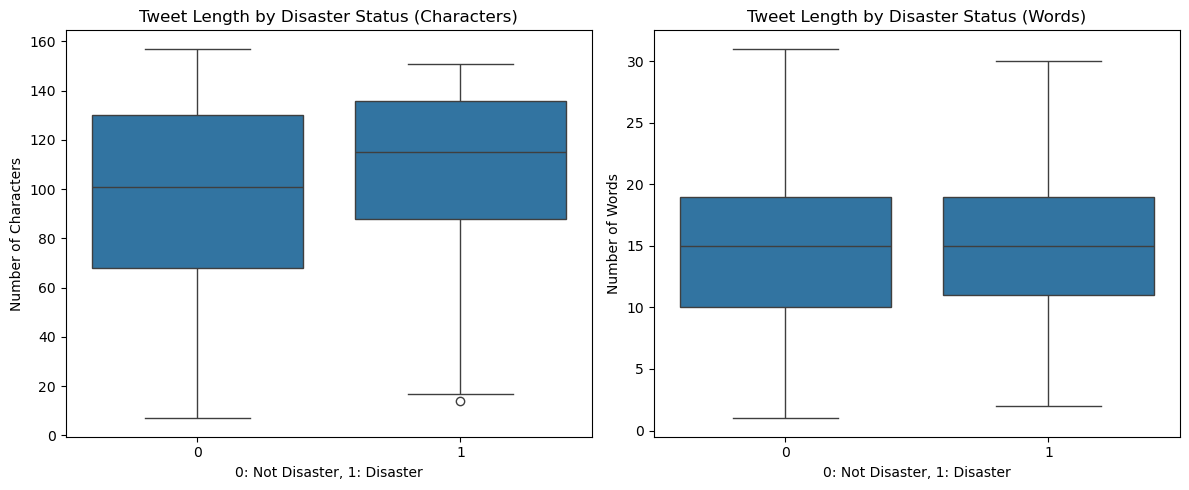

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='text_length', data=df)
plt.title('Tweet Length by Disaster Status (Characters)')
plt.xlabel('0: Not Disaster, 1: Disaster')
plt.ylabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='word_count', data=df)
plt.title('Tweet Length by Disaster Status (Words)')
plt.xlabel('0: Not Disaster, 1: Disaster')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

## 3. Text Preprocessing

Before feeding the text data into our model, we need to clean and standardize it. This includes removing punctuation, special characters, URLs, and converting text to lowercase.

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
df['cleaned_text'] = df['text'].apply(clean_text)
comparison = pd.DataFrame({
    'Original Text': df['text'].head(5),
    'Cleaned Text': df['cleaned_text'].head(5)
})
comparison

,Original Text,Cleaned Text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this may allah for...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby as smoke fr...


In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [10]:
df['processed_text'] = df['cleaned_text'].apply(remove_stopwords_and_lemmatize)

comparison = pd.DataFrame({
    'Cleaned Text': df['cleaned_text'].head(5),
    'Processed Text (Stopwords Removed & Lemmatized)': df['processed_text'].head(5)
})
comparison

,Cleaned Text,Processed Text (Stopwords Removed & Lemmatized)
0,our deeds are the reason of this may allah for...,deed reason may allah forgive u
1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...,resident asked shelter place notified officer ...
3,people receive evacuation orders in california,people receive evacuation order california
4,just got sent this photo from ruby as smoke fr...,got sent photo ruby smoke pours school


## 4. Text Tokenization and Sequence Preparation

In [11]:
X = df['processed_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6090
Test set size: 1523


In [12]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"Number of unique words in training data: {len(tokenizer.word_index)}")

Vocabulary size: 11052
Number of unique words in training data: 11051


In [13]:
max_length = max([len(seq) for seq in X_train_seq])
print(f"Maximum sequence length: {max_length}")

max_length = 50 

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

print(f"Shape of padded training data: {X_train_padded.shape}")
print(f"Shape of padded test data: {X_test_padded.shape}")

Maximum sequence length: 23
Shape of padded training data: (6090, 50)
Shape of padded test data: (1523, 50)


## 5. Building the RNN Model

We'll create an RNN model with LSTM layers, which are well-suited for sequential data like text.

In [14]:
embedding_dim = 100

model = Sequential()

model.add(Embedding(input_dim=min(max_words, vocab_size),
                    output_dim=embedding_dim,
                    input_length=max_length))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(4, return_sequences=True)))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'), name='output')

2025-04-26 21:32:15.326058: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 21:32:15.326090: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-26 21:32:15.326093: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-26 21:32:15.326129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 21:32:15.326143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 64)            4

## 6. Model Training

Now we'll train the model using our preprocessed data, with early stopping to prevent overfitting.

In [16]:
history = model.fit(
    X_train_padded, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/25


2025-04-26 21:32:20.621968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.627184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.642421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.753812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.768533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.845874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:21.860243: I tensorflow/core/grappler/optimizers/cust

  1/172 [..............................] - ETA: 19:21 - loss: 0.6903 - accuracy: 0.5638

2025-04-26 21:32:23.213431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.6804

2025-04-26 21:32:44.904027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.353902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.364657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.446135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.457438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.546208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:32:45.581197: I tensorflow/core/grappler/optimizers/cust

172/172 [==============================] - 31s 141ms/step - loss: 0.6143 - accuracy: 0.6804 - val_loss: 0.5334 - val_accuracy: 0.7582
Epoch 2/25
172/172 [==============================] - 21s 120ms/step - loss: 0.4103 - accuracy: 0.8473 - val_loss: 0.5146 - val_accuracy: 0.7659
Epoch 3/25
172/172 [==============================] - 20s 118ms/step - loss: 0.3087 - accuracy: 0.8992 - val_loss: 0.6175 - val_accuracy: 0.7666
Epoch 4/25
172/172 [==============================] - 20s 116ms/step - loss: 0.2747 - accuracy: 0.9191 - val_loss: 0.6958 - val_accuracy: 0.7590
Epoch 5/25
172/172 [==============================] - 19s 113ms/step - loss: 0.2343 - accuracy: 0.9375 - val_loss: 0.6959 - val_accuracy: 0.7343
Epoch 6/25
172/172 [==============================] - 19s 112ms/step - loss: 0.2069 - accuracy: 0.9431 - val_loss: 0.7857 - val_accuracy: 0.7507
Epoch 7/25
172/172 [==============================] - 19s 113ms/step - loss: 0.1807 - accuracy: 0.9526 - val_loss: 0.7589 - val_accuracy: 0.7

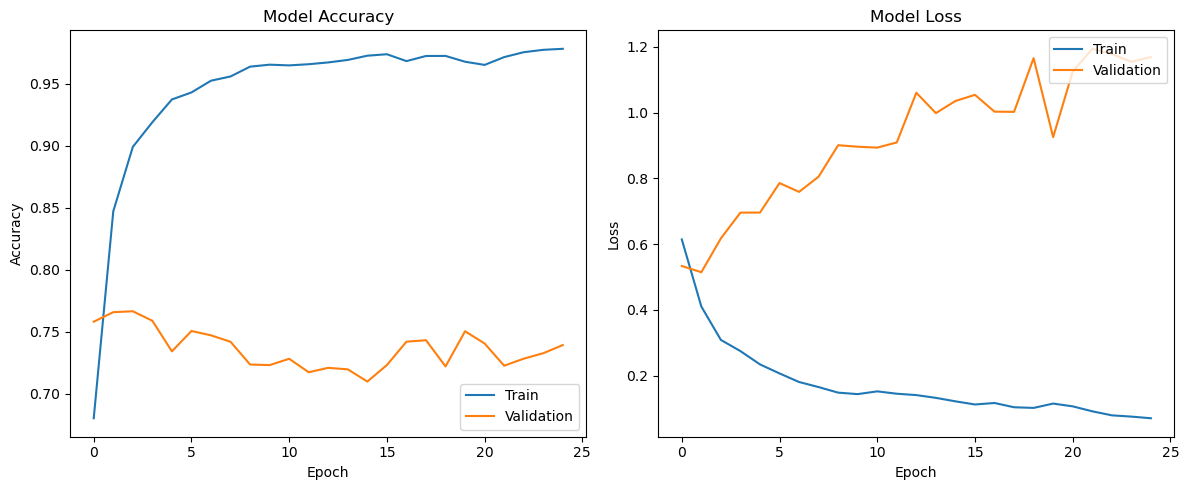

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate the model's performance on the test set.

In [18]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

48/48 [==============================] - 2s 41ms/step - loss: 1.0493 - accuracy: 0.7484
Test Loss: 1.0493
Test Accuracy: 0.7484


In [29]:
y_pred_proba = model.predict(X_test_padded)
y_pred = y_pred_proba[:, -1, 0]
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

48/48 [==============================] - 2s 38ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       869
           1       0.75      0.62      0.68       654

    accuracy                           0.75      1523
   macro avg       0.75      0.73      0.73      1523
weighted avg       0.75      0.75      0.74      1523



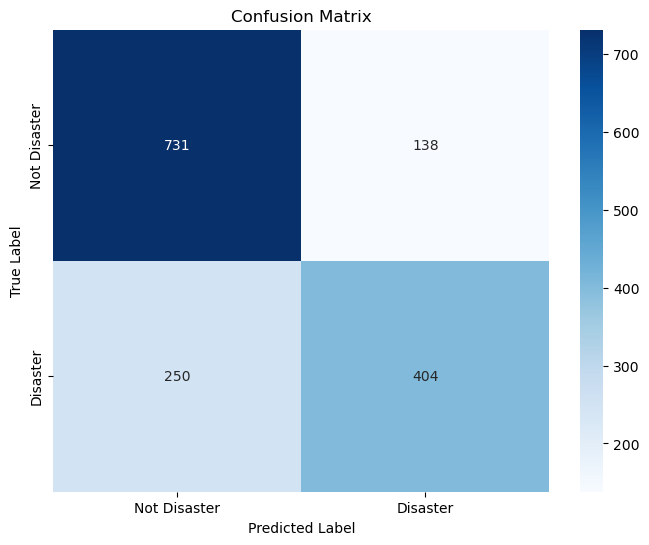

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 8. Model Testing with Sample Tweets

Let's test our model with some sample tweets to see how it performs in practice.

In [30]:
test_df = pd.read_csv("~/nlp-getting-started/test.csv")
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['processed_text'] = test_df['cleaned_text'].apply(remove_stopwords_and_lemmatize)

X_test_new = test_df['processed_text']
X_test_new_seq = tokenizer.texts_to_sequences(X_test_new)
X_test_new_padded = pad_sequences(X_test_new_seq, maxlen=max_length, padding='post')

In [36]:
y_pred_proba_new_padded = model.predict(X_test_new_padded)
y_pred_new_padded = y_pred_proba_new_padded[:, -1, 0]
y_pred_new_padded = (y_pred_new_padded > 0.5).astype(int)

102/102 [==============================] - 4s 42ms/step


In [37]:
results_df = pd.DataFrame({'id': test_df['id'], 'target': y_pred_new_padded})

results_df.to_csv("~/nlp-getting-started/results.csv", index=False)

## 9. Visualizing Predictions

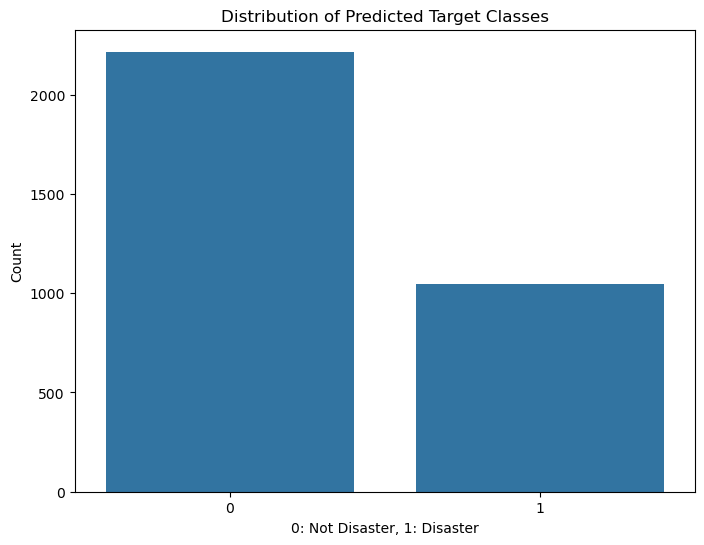

In [38]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=results_df)
plt.title('Distribution of Predicted Target Classes')
plt.xlabel('0: Not Disaster, 1: Disaster')
plt.ylabel('Count')
plt.show()

In [ ]:
# # Save the model and tokenizer for future use
# model.save('dixsaster_tweet_classifier.h5')

# import pickle
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print("Model and tokenizer saved successfully!")